In [1]:
%load_ext autoreload
%autoreload 1

import os

import numpy as np
from scipy.special import expit
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.special import logit
from scipy.stats import norm
import seaborn as sns


from utils import get_variables, expit_transform, treatment_assigment, get_potential_outcomes
%aimport utils


# Random variables defintions

In [2]:
amount_of_vars = 4
intercept = 0
mean = 0
std = 1
n = 10000

noise_mean = 1
noise_std = 0

num_of_experiments = 1000


variables, noise = get_variables(mean_=mean, std_=std, n_=n, m_=amount_of_vars, noise_mean_=noise_mean, noise_std_=noise_std )



# Prop model

## $\pi$ model

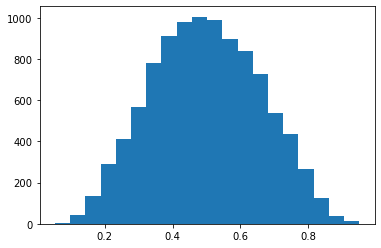

In [3]:
coef = np.array([-0.1, .05, .2, -.05])

exp = expit_transform(coef, variables)
plt.hist(exp, bins=20);

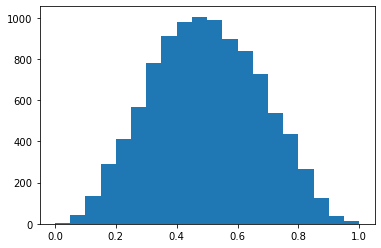

In [4]:

exp2 = (exp - exp.min()) / (exp.max() - exp.min())


plt.hist(exp2, bins=20);

## Treatment assigment

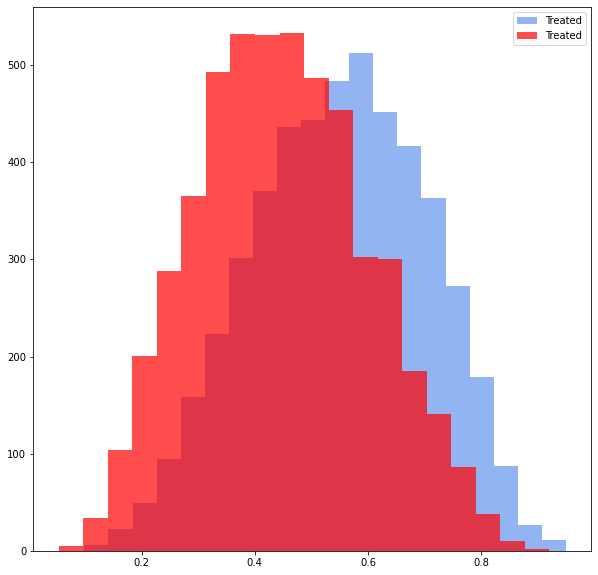

In [5]:



t = treatment_assigment(exp)

fig = plt.figure(figsize=(10, 10))

plt.hist(exp[t == 1], bins=20, color='cornflowerblue', alpha=0.7, label= 'Treated');
plt.hist(exp[t == 0], bins=20, color='red', alpha=0.7, label= 'Treated');

plt.legend();

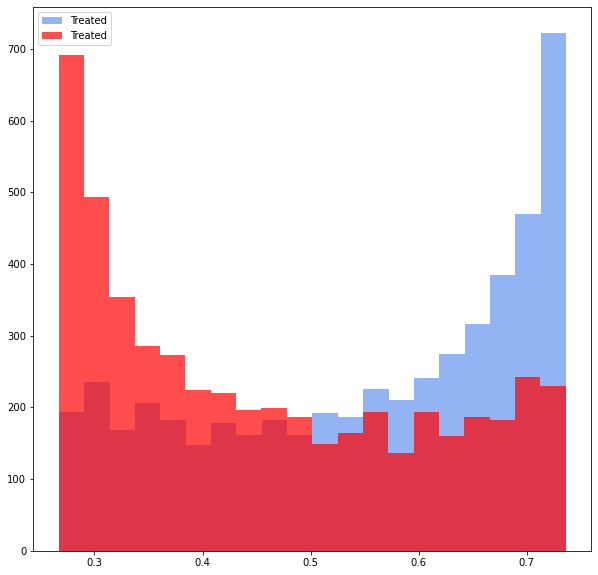

In [647]:
fig = plt.figure(figsize=(10, 10))

plt.hist(exp2[t == 1], bins=20, color='cornflowerblue', alpha=0.7, label= 'Treated');
plt.hist(exp2[t == 0], bins=20, color='red', alpha=0.7, label= 'Treated');

plt.legend();

# Outcome model

In [6]:
y_coef = np.array([5, 1.2, 3.6, 1.2, 1.2, .0])

potential_outcomes_lst = utils.get_potential_outcomes(variables, y_coef, noise)

y = np.where(t == 1, potential_outcomes_lst[1], potential_outcomes_lst[0])


In [7]:
ate = (potential_outcomes_lst[1]  - potential_outcomes_lst[0]).mean()
ate_hat = utils.calc_ipw(y, t, exp)

In [8]:
ate - ate_hat

-0.08080462529203114

In [9]:
ate_hat / ate

1.0161609250584063

# Calibration Calculation

In [314]:

err_s = pd.Series(err)
brier_score = brier_score_loss(t, exp)
brier = pd.Series(brier_score, index=['brier'])

calib_res_df = err_s.describe(percentiles=[.1, .5, .9]).append(brier).to_frame().T



In [364]:
ate_hat = utils.calc_ipw(y, t, exp)
utils.generate_calib_error_df(t, exp).assign(ATE=ate_hat)

,count,mean,std,min,10%,50%,90%,max,brier,ATE
0,10000.0,0.019038,0.009125,0.000021,0.005447,0.020683,0.029102,0.052205,0.225334,4.509613


In [1014]:
ate_hat2 = utils.calc_ipw(y, t, exp3)
utils.generate_calib_error_df(t, exp3).assign(ATE=ate_hat2)

,count,mean,std,min,10%,50%,90%,max,brier,ATE
0,10000.0,0.01872,0.009135,0.000003,0.006628,0.019957,0.029867,0.045586,0.224086,4.477231


In [433]:
pd.Series(exp2).describe()

count    10000.000000
mean         0.501465
std          0.108217
min          0.147051
25%          0.426389
50%          0.501699
75%          0.576626
max          0.870538
dtype: float64

## to check calibration methods

In [466]:
# exp2 = expit(exp ** 2)

from scipy.special import logit
from scipy.stats import norm

exp2 = min_max_transform(logit(exp))

exp2 = min_max_transform(np.arctan(logit(exp)))

exp2 = min_max_transform(np.tanh(logit(exp)))

exp2 = utils.expit_transform(coef, variables, exp_scale=0.5)

exp2 = utils.expit_transform(coef, variables, exp_scale=5)


In [467]:
norm.ppf(logit(exp))

array([        nan,         nan, -0.05542964, ...,         nan,
               nan,  0.05772639])

In [477]:
exp2 = norm.cdf(logit(exp)*2)

In [ ]:
expirments = {
    'identity': lambda x: x
    'min_max': lambda x: min_max_transform(logit(x)),
    'min_max_arctan': lambda x: min_max_transform(np.arctan(logit(exp))),
    'min_max_tanh': lambda x: min_max_transform(np.tanh(logit(exp))),
    'scaled_expit_0.5': lambda x: expit(logit(exp)*0.5),
    'scaled_expit_5': lambda x: expit(logit(exp)*5),
    'probit': lambda x: norm.cdf(logit(exp)),
    'scaled_probit_0.5': lambda x: norm.cdf(logit(exp) * 2)
}

In [630]:
exp2 = experiments['scaled_expit_0.25'](exp)

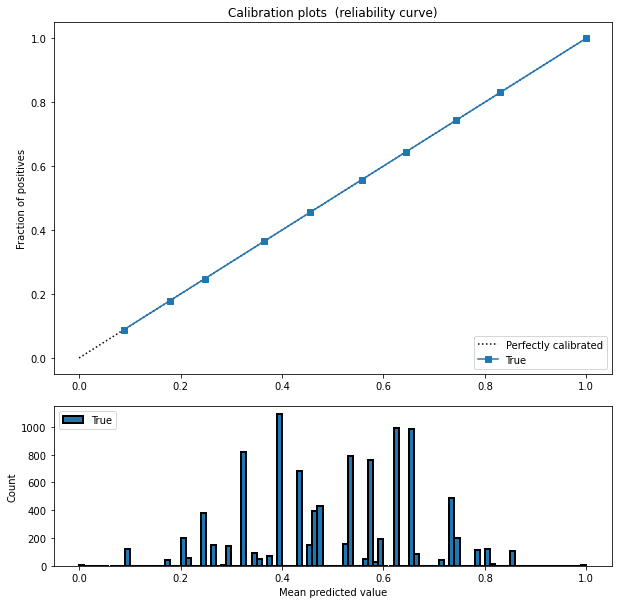

In [1013]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")


fraction_of_positives, mean_predicted_value = \
    calibration_curve(t, exp2, n_bins=10)

name = "True"

ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
         label=f"{name}")

ax2.hist(exp2, range=(0, 1), bins=100, label=name, histtype="bar", lw=2, alpha=1, fc=None, edgecolor='black')

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper left", ncol=2)

In [193]:
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant

In [197]:
lr = Logit(t, add_constant(exp))

In [198]:
res = lr.fit()

Optimization terminated successfully.
         Current function value: 0.638424
         Iterations 5


In [199]:
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.079      
Dependent Variable: y                AIC:              12772.4852 
Date:               2021-06-16 09:45 BIC:              12786.9059 
No. Observations:   10000            Log-Likelihood:   -6384.2    
Df Model:           1                LL-Null:          -6931.0    
Df Residuals:       9998             LLR p-value:      8.7230e-240
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     5.0000                                        
-------------------------------------------------------------------
            Coef.    Std.Err.     z      P>|z|    [0.025    0.975] 
-------------------------------------------------------------------
const      -11.6532    0.3776  -30.8646  0.0000  -12.3932  -10.9132
x1          18.7691    0.6060   30.9710  0.0000   17.5813   19.9568
==================================================================

"""

# full simulation

In [10]:
amount_of_vars = 4
intercept = 0
mean = 0
std = 1
n = 10000

noise_mean = 1
noise_std = 0

coef = np.array([-0.1, .05, .2, -.05])
y_coef = np.array([5, 1.2, 3.6, 1.2, 1.2, .0])

# num_of_experiments = 100

# calib_df = utils.generate_simulation(m=amount_of_vars, mean=mean, std=std, n=n, noise_mean=noise_mean,
#                                      noise_std=noise_std, coef=coef, y_coef=y_coef, num_of_experiments=num_of_experiments)

# calib_df['type'] = 'true_prop'
# calib_df

In [483]:
expirments = {
    'identity': lambda x: x,
    'min_max': lambda x: utils.min_max_transform(logit(x)),
    'min_max_arctan': lambda x: utils.min_max_transform(np.arctan(logit(x))),
    'min_max_tanh': lambda x: utils.min_max_transform(np.tanh(logit(x))),
    'scaled_expit_0.5': lambda x: expit(logit(x)*0.5),
    'scaled_expit_5': lambda x: expit(logit(x)*5),
    'probit': lambda x: norm.cdf(logit(x)),
    'scaled_probit_0.5': lambda x: norm.cdf(logit(x) * 2)
}

num_of_experiments = 10


calib_df = utils.generate_simulation(m=amount_of_vars, mean=mean, std=std, n=n, noise_mean=noise_mean,
                                     noise_std=noise_std, coef=coef, y_coef=y_coef, num_of_experiments=num_of_experiments, experiments=expirments)

# calib_df['type'] = 'true_prop'
calib_df

100%|██████████| 10/10 [04:58<00:00, 29.86s/it]


,count,mean,std,min,10%,50%,90%,max,brier,type,ATE
0,10000.0,0.017592,0.010052,1.034629e-05,0.005424,0.013638,0.030995,0.031278,0.225836,identity,5.298871
0,10000.0,0.037248,0.019514,3.651573e-06,0.010456,0.035554,0.064600,0.067636,0.226408,min_max,5.558454
0,10000.0,0.042609,0.025858,6.286795e-07,0.008737,0.041400,0.077685,0.113483,0.230815,min_max_arctan,4.359146
0,10000.0,0.076218,0.043313,7.828786e-06,0.015968,0.076763,0.134405,0.168471,0.237943,min_max_tanh,2.845422
0,10000.0,0.077426,0.046167,7.210562e-07,0.016477,0.075248,0.140561,0.236810,0.230809,scaled_expit_0.5,6.092696
...,...,...,...,...,...,...,...,...,...,...,...
9,10000.0,0.072012,0.038097,2.021944e-05,0.016372,0.074890,0.121673,0.146772,0.235333,min_max_tanh,2.945169
9,10000.0,0.081015,0.050864,1.589878e-05,0.016152,0.076766,0.151047,0.274698,0.230012,scaled_expit_0.5,6.155836
9,10000.0,0.191953,0.071414,2.209576e-04,0.075507,0.221098,0.256576,0.261410,0.281276,scaled_expit_5,-264.806278
9,10000.0,0.042656,0.026152,2.972898e-07,0.007383,0.041623,0.078956,0.108247,0.229404,probit,3.960627


In [98]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import GridSearchCV

tuned_parameters = [{'max_depth': [1,2, 3, 4],
                     'n_estimators': [1, 5, 10, 100]}]

scores = 'neg_brier_score'

model_experiments = {
    'GBT': GradientBoostingClassifier(random_state=42),
    'rf': RandomForestClassifier(random_state=42, n_jobs=-1),
    'lr': LogisticRegression(random_state=42, C=1, n_jobs=-1),
    'GBT_cv': GridSearchCV(GradientBoostingClassifier(), tuned_parameters, scoring=scores, n_jobs=-1),
    'rf_cv': GridSearchCV(RandomForestClassifier(), tuned_parameters, scoring=scores, n_jobs=-1)
}

In [100]:
scaling_range = [0.125, 0.25, 1/3, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 3]

experiments = utils.scaled_for_experiments(scaling_range)

experiments.update(model_experiments)

num_of_experiments = 10


calib_df = utils.generate_simulation(
    m=amount_of_vars, 
    mean=mean, std=std, n=n, 
    noise_mean=noise_mean,
    noise_std=noise_std,
    coef=coef,
    y_coef=y_coef,
    num_of_experiments=num_of_experiments,
    experiments=experiments,
    post_colab_func=utils.sigmoid_calib,
    save=True
)

calib_df['ATE_error'] = (calib_df['ATE'] - y_coef[0]).pipe(lambda x: np.sqrt(x ** 2))


calib_df

100%|██████████| 10/10 [17:59<00:00, 107.91s/it]


,count,mean,std,min,10%,50%,90%,max,brier,type,scale,calibration_type,ATE,ATE_error
0,10000.0,0.129340,0.090970,2.272057e-05,0.020340,0.116343,0.256144,0.543978,0.243467,scaled_expit_0.125,0.125,None,6.429219,1.429219
0,10000.0,0.016587,0.012292,3.608696e-06,0.001356,0.016034,0.033539,0.053113,0.224313,scaled_expit_0.125_calibrated,0.125,sigmoid_calib,4.602067,0.397933
0,10000.0,0.111990,0.078017,1.704322e-05,0.017583,0.101658,0.220557,0.452036,0.237951,scaled_expit_0.25,0.25,None,6.130559,1.130559
0,10000.0,0.016493,0.012408,7.217785e-07,0.001295,0.015772,0.033727,0.054074,0.224313,scaled_expit_0.25_calibrated,0.25,sigmoid_calib,4.605735,0.394265
0,10000.0,0.100587,0.069594,2.200222e-06,0.015784,0.091821,0.197348,0.392840,0.234843,scaled_expit_0.3333333333333333,0.333333,None,5.944956,0.944956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,10000.0,0.017800,0.013542,1.536798e-05,0.005336,0.012942,0.036868,0.082776,0.224359,lr_calibrated,lr_model,sigmoid_calib,5.037710,0.037710
9,10000.0,0.034755,0.025719,1.603900e-05,0.004813,0.029517,0.071851,0.132413,0.219189,GBT_cv,GBT_cv_model,None,5.179461,0.179461
9,10000.0,0.015311,0.016252,9.163316e-07,0.000209,0.009045,0.040397,0.073228,0.219084,GBT_cv_calibrated,GBT_cv_model,sigmoid_calib,4.985029,0.014971
9,10000.0,0.049803,0.039804,4.676225e-06,0.005172,0.041204,0.108963,0.195611,0.222264,rf_cv,rf_cv_model,None,5.482430,0.482430


In [14]:
cm = sns.diverging_palette(240, 50, s=80, l=70,
                           n=calib_df['scale'].nunique(),
                           as_cmap=True, 
                           center='light'
                          )


# calib_df['scale'].apply(np.log).map(cm)

# sns.diverging_palette(240, 500, s=60, n=8)

cm

In [967]:
sns.diverging_palette(240, 18, s=80, l=50,sep=1,
                           n=calib_df['scale'].nunique(),
                      center='light'
#                            as_cmap=True, 
                          )

[(0.23010319520718325, 0.4887423024302338, 0.6690987262229071),
 (0.36965431696031037, 0.5783810431367898, 0.7244487514404696),
 (0.5147874835835626, 0.6716053334716081, 0.7820127776667346),
 (0.6571187253403653, 0.7630298459656776, 0.8384654791679281),
 (0.8022518919636176, 0.8562541363004958, 0.8960295053941931),
 (0.9502644313749016, 0.9458084295205358, 0.9453810551713931),
 (0.9210472029754666, 0.8188485935522556, 0.7979827102009093),
 (0.8897677231370339, 0.688549926764675, 0.6464475798844067),
 (0.8590921214775731, 0.5607667916300699, 0.497837970037506),
 (0.8278126416391404, 0.4304681248424893, 0.3463028397210033),
 (0.7977362187175703, 0.30518094523904643, 0.20059598364744313)]

In [971]:
sns.diverging_palette(240, 18, s=80, l=50,sep=1,
                           n=calib_df['scale'].nunique(),
                      center='light'
#                            as_cmap=True, 
                          )

[(0.23010319520718325, 0.4887423024302338, 0.6690987262229071),
 (0.36965431696031037, 0.5783810431367898, 0.7244487514404696),
 (0.5147874835835626, 0.6716053334716081, 0.7820127776667346),
 (0.6571187253403653, 0.7630298459656776, 0.8384654791679281),
 (0.8022518919636176, 0.8562541363004958, 0.8960295053941931),
 (0.9502644313749016, 0.9458084295205358, 0.9453810551713931),
 (0.9210472029754666, 0.8188485935522556, 0.7979827102009093),
 (0.8897677231370339, 0.688549926764675, 0.6464475798844067),
 (0.8590921214775731, 0.5607667916300699, 0.497837970037506),
 (0.8278126416391404, 0.4304681248424893, 0.3463028397210033),
 (0.7977362187175703, 0.30518094523904643, 0.20059598364744313)]

In [101]:
model_rows = pd.to_numeric(calib_df['scale'], errors='coerce').isna()

In [708]:
calib_df['calibration_type_temp'] = calib_df['calibration_type'].fillna('None')

In [28]:
calib_df[~model_rows].sort_values('scale').groupby('type')['scale'].max().rank(method='first')

type
scaled_expit_0.125                             1.0
scaled_expit_0.125_calibrated                  2.0
scaled_expit_0.25                              3.0
scaled_expit_0.25_calibrated                   4.0
scaled_expit_0.3333333333333333                5.0
scaled_expit_0.3333333333333333_calibrated     6.0
scaled_expit_0.5                               7.0
scaled_expit_0.5_calibrated                    8.0
scaled_expit_0.75                              9.0
scaled_expit_0.75_calibrated                  10.0
scaled_expit_1                                11.0
scaled_expit_1.25                             13.0
scaled_expit_1.25_calibrated                  14.0
scaled_expit_1.5                              15.0
scaled_expit_1.5_calibrated                   16.0
scaled_expit_1.75                             17.0
scaled_expit_1.75_calibrated                  18.0
scaled_expit_1_calibrated                     12.0
scaled_expit_2                                19.0
scaled_expit_2_calibrated 

In [102]:
# [cm[i] for i in range(cm)]

# np.dot(cm(-np.inf), 256)
calib_df[model_rows]

,count,mean,std,min,10%,50%,90%,max,brier,type,scale,calibration_type,ATE,ATE_error
0,10000.0,0.049033,0.035277,1.692077e-05,0.006424,0.043803,0.099658,0.183286,0.212255,GBT,GBT_model,None,4.995255,0.004745
0,10000.0,0.017681,0.017562,4.076141e-06,0.001734,0.009506,0.045153,0.083339,0.211335,GBT_calibrated,GBT_model,sigmoid_calib,4.616798,0.383202
0,10000.0,0.153765,0.059776,1.491342e-03,0.080864,0.154534,0.227704,0.356196,0.033616,rf,rf_model,None,3.888644,1.111356
0,10000.0,0.000248,0.002763,5.661040e-08,0.000002,0.000036,0.000165,0.150651,0.000011,rf_calibrated,rf_model,sigmoid_calib,3.379044,1.620956
0,10000.0,0.016561,0.011953,1.792300e-06,0.001581,0.016121,0.033079,0.053980,0.224291,lr,lr_model,None,4.884310,0.115690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,10000.0,0.017800,0.013542,1.536798e-05,0.005336,0.012942,0.036868,0.082776,0.224359,lr_calibrated,lr_model,sigmoid_calib,5.037710,0.037710
9,10000.0,0.034755,0.025719,1.603900e-05,0.004813,0.029517,0.071851,0.132413,0.219189,GBT_cv,GBT_cv_model,None,5.179461,0.179461
9,10000.0,0.015311,0.016252,9.163316e-07,0.000209,0.009045,0.040397,0.073228,0.219084,GBT_cv_calibrated,GBT_cv_model,sigmoid_calib,4.985029,0.014971
9,10000.0,0.049803,0.039804,4.676225e-06,0.005172,0.041204,0.108963,0.195611,0.222264,rf_cv,rf_cv_model,None,5.482430,0.482430


In [717]:
hue_s = calib_df.sort_values('scale').groupby('type')['scale'].max().apply(np.log).map(cm)

# sns.relplot(x='mean', y='ATE_error', data=calib_df, hue='type', col='calibration_type_temp', kind="scatter")


Text(0, 0.5, 'ATE Error')

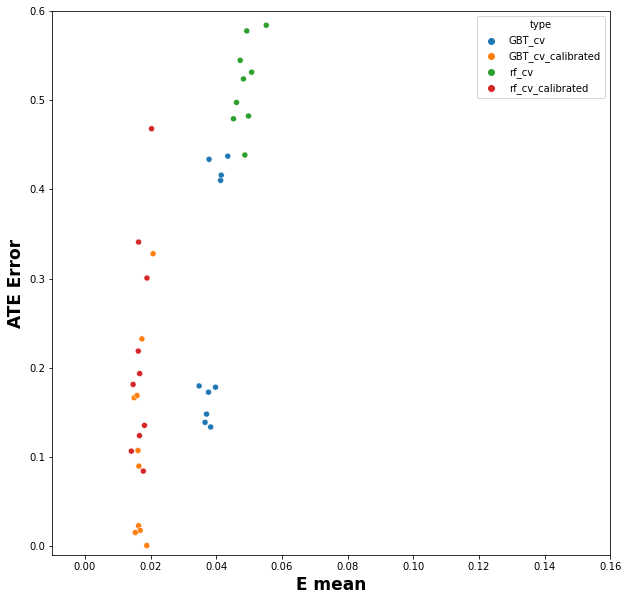

In [128]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='mean', y='ATE_error', data=calib_df[model_rows].loc[lambda df: df['type'].str.contains('cv')], hue='type')
plt.ylim(-0.01, 0.6)
plt.xlim(-.01, 0.16)

plt.xlabel('E mean', fontdict={'weight': 'bold', 'size':17})
plt.ylabel('ATE Error', fontdict={'weight': 'bold', 'size':17})


In [664]:
calib_df.loc[calib_df['type'].str.contains('calibrated')]

,count,mean,std,min,10%,50%,90%,max,brier,type,ATE,ATE_error
0,10000.0,0.017711,0.009496,1.926554e-06,0.004877,0.017885,0.030353,0.046776,0.225275,scaled_expit_0.25_calibrated,5.333900,0.333900
0,10000.0,0.017640,0.009604,1.633991e-05,0.004824,0.017631,0.030553,0.047870,0.225276,scaled_expit_0.3333333333333333_calibrated,5.334835,0.334835
0,10000.0,0.017463,0.009921,7.029396e-06,0.004714,0.016936,0.031074,0.050633,0.225279,scaled_expit_0.5_calibrated,5.337596,0.337596
0,10000.0,0.017177,0.010637,1.180921e-05,0.004470,0.015558,0.032409,0.055216,0.225297,scaled_expit_0.75_calibrated,5.344151,0.344151
0,10000.0,0.016975,0.011563,4.219667e-07,0.004328,0.014019,0.034114,0.058971,0.225336,scaled_expit_1_calibrated,5.353730,0.353730
...,...,...,...,...,...,...,...,...,...,...,...,...
9,10000.0,0.017608,0.011617,1.333936e-06,0.004117,0.016384,0.033247,0.068085,0.225646,scaled_expit_0.75_calibrated,4.892284,0.107716
9,10000.0,0.017348,0.012402,1.142629e-06,0.004077,0.014632,0.034208,0.071063,0.225667,scaled_expit_1_calibrated,4.904760,0.095240
9,10000.0,0.017495,0.014020,4.263244e-06,0.004972,0.011960,0.037691,0.071791,0.225798,scaled_expit_1.5_calibrated,4.935086,0.064914
9,10000.0,0.018481,0.014967,1.960861e-06,0.005542,0.011750,0.040719,0.067944,0.226043,scaled_expit_2_calibrated,4.971186,0.028814


In [115]:
temp_scale_df = calib_df[~model_rows].copy()

temp_scale_df['scale'] = temp_scale_df['scale'].astype('float64')

/Users/romg/opt/anaconda3/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


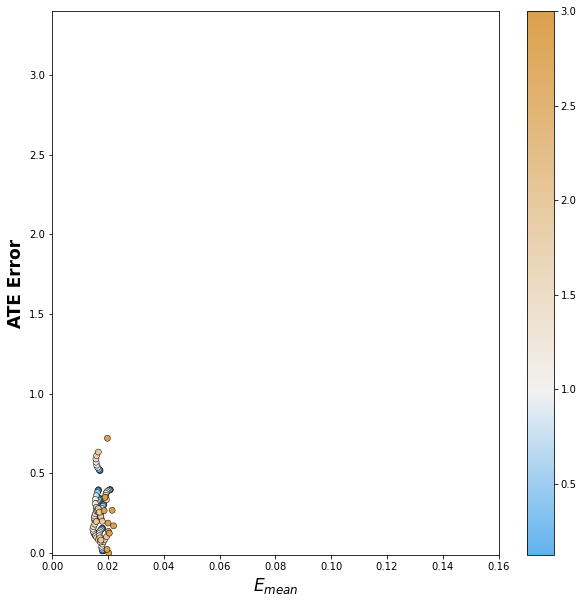

In [268]:
temp_df = temp_scale_df.loc[temp_scale_df['type'].str.contains('calibrated')]

utils.plot_calibration(df=temp_df,
                       calib_metric="mean",
                       calib_metric_label=r"$E_{mean}$",
                       upper_y_bound=3.4,
                       upper_x_bound=0.16,
                       lower_x_bound=0,
                       cm=cm
                      )


# arrows = get_arrows(temp_df, calib_metric='mean')

# arrows.apply(plot_arrow);

In [831]:
calib_df.loc[calib_df['type'].str.contains('calibrated')].sort_values('scale')['type'].unique()

array(['scaled_expit_0.125_calibrated', 'scaled_expit_0.25_calibrated',
       'scaled_expit_0.3333333333333333_calibrated',
       'scaled_expit_0.5_calibrated', 'scaled_expit_0.75_calibrated',
       'scaled_expit_1_calibrated', 'scaled_expit_1.25_calibrated',
       'scaled_expit_1.5_calibrated', 'scaled_expit_1.75_calibrated',
       'scaled_expit_2_calibrated', 'scaled_expit_3_calibrated'],
      dtype=object)

/Users/romg/opt/anaconda3/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


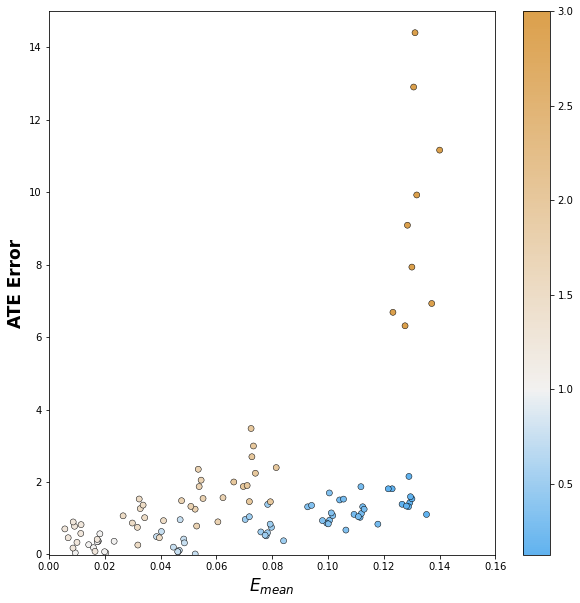

In [117]:
utils.plot_calibration(df=temp_scale_df.loc[~temp_scale_df['type'].str.contains('calibrated')],
                       calib_metric="mean",
                       calib_metric_label=r"$E_{mean}$",
                       upper_y_bound=15,
                       upper_x_bound=0.16,
                       cm=cm
                      )
# plt.legend(loc=2)

In [1004]:
calib_df.sort_values('ATE_error').head(40)

,count,mean,std,min,10%,50%,90%,max,brier,type,scale,calibration_type,ATE,ATE_error
8,10000.0,0.020955,0.016080,2.726291e-06,0.001643,0.018137,0.043122,0.054005,0.225234,scaled_expit_3_calibrated,3.000000,sigmoid_calib,4.975830,0.024170
9,10000.0,0.019516,0.015764,3.625387e-07,0.002399,0.014568,0.043289,0.057435,0.227669,scaled_expit_3_calibrated,3.000000,sigmoid_calib,5.025480,0.025480
1,10000.0,0.003815,0.003569,3.875845e-09,0.000473,0.003625,0.008254,0.022287,0.223169,scaled_expit_1.25,1.250000,None,5.031781,0.031781
9,10000.0,0.017043,0.016795,1.147093e-06,0.001549,0.010205,0.042177,0.074751,0.226690,scaled_expit_2_calibrated,2.000000,sigmoid_calib,4.941473,0.058527
7,10000.0,0.011386,0.007903,3.011267e-06,0.003285,0.009549,0.023909,0.035933,0.226565,scaled_expit_1.25,1.250000,None,4.926085,0.073915
9,10000.0,0.016235,0.016880,2.754845e-06,0.001066,0.008914,0.041377,0.080353,0.226466,scaled_expit_1.75_calibrated,1.750000,sigmoid_calib,4.920879,0.079121
4,10000.0,0.014160,0.010000,5.796162e-07,0.003297,0.011514,0.028351,0.062276,0.226968,scaled_expit_1.25,1.250000,None,5.089709,0.089709
9,10000.0,0.015477,0.016755,8.214794e-08,0.000898,0.007650,0.040212,0.086089,0.226263,scaled_expit_1.5_calibrated,1.500000,sigmoid_calib,4.901073,0.098927
8,10000.0,0.018246,0.015594,2.063008e-06,0.003270,0.013288,0.041412,0.063264,0.224484,scaled_expit_2_calibrated,2.000000,sigmoid_calib,4.889665,0.110335
9,10000.0,0.014974,0.016327,8.542291e-07,0.002012,0.006487,0.038708,0.091478,0.226091,scaled_expit_1.25_calibrated,1.250000,sigmoid_calib,4.882341,0.117659


In [983]:
calib_df.query('scale == 1').sort_values('ATE_error')

,count,mean,std,min,10%,50%,90%,max,brier,type,scale,calibration_type,ATE,ATE_error
9,10000.0,0.014619,0.015807,1.558731e-06,0.003278,0.005532,0.036849,0.095783,0.225954,scaled_expit_1_calibrated,1.0,sigmoid_calib,4.864907,0.135093
8,10000.0,0.019575,0.010491,1.279869e-05,0.004615,0.021130,0.029022,0.056227,0.224022,scaled_expit_1,1.0,None,4.809583,0.190417
8,10000.0,0.017401,0.012664,4.455075e-06,0.003129,0.015350,0.034263,0.067481,0.224046,scaled_expit_1_calibrated,1.0,sigmoid_calib,4.807543,0.192457
2,10000.0,0.016380,0.011937,8.814485e-06,0.004649,0.010541,0.035170,0.064429,0.225198,scaled_expit_1_calibrated,1.0,sigmoid_calib,5.213307,0.213307
7,10000.0,0.015703,0.013536,8.396054e-07,0.002080,0.011952,0.036323,0.062236,0.225509,scaled_expit_1_calibrated,1.0,sigmoid_calib,5.223533,0.223533
3,10000.0,0.016073,0.007844,1.290228e-05,0.004570,0.017783,0.024871,0.043677,0.225500,scaled_expit_1,1.0,None,5.223782,0.223782
2,10000.0,0.018110,0.009168,7.683204e-06,0.005570,0.018035,0.030610,0.052699,0.225074,scaled_expit_1,1.0,None,5.230960,0.230960
7,10000.0,0.015250,0.011137,6.367909e-06,0.002159,0.012916,0.032113,0.045475,0.225490,scaled_expit_1,1.0,None,5.240575,0.240575
9,10000.0,0.011527,0.014999,4.086120e-07,0.000690,0.004837,0.033689,0.093810,0.225777,scaled_expit_1,1.0,None,4.738197,0.261803
6,10000.0,0.019745,0.014656,3.269082e-06,0.006918,0.013927,0.044655,0.082325,0.224563,scaled_expit_1,1.0,None,5.263485,0.263485


In [326]:
def min_max_transform(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

calib_df_min_max = utils.generate_simulation(m=amount_of_vars, mean=mean, std=std, n=n, noise_mean=noise_mean,
                                     noise_std=noise_std, coef=coef, y_coef=y_coef, num_of_experiments=num_of_experiments, prop_func=min_max_transform)

calib_df_min_max['type'] = 'min_max'
calib_df_min_max

100%|██████████| 100/100 [06:21<00:00,  3.81s/it]


,count,mean,std,min,10%,50%,90%,max,brier,ATE
0,10000.0,0.007169,0.007015,1.599103e-06,0.001566,0.004726,0.017724,0.043717,0.225639,4.467960
1,10000.0,0.006022,0.005233,8.987875e-07,0.000831,0.003135,0.013660,0.023615,0.225555,5.003496
2,10000.0,0.020164,0.008352,1.067833e-05,0.005727,0.023684,0.027738,0.040211,0.223200,4.577017
3,10000.0,0.015027,0.009676,1.638426e-03,0.002397,0.014672,0.028179,0.034149,0.222593,4.980606
4,10000.0,0.004855,0.004112,1.769438e-06,0.001512,0.004029,0.010134,0.029789,0.225033,-20047.416128
...,...,...,...,...,...,...,...,...,...,...
95,10000.0,0.004993,0.003806,9.376297e-07,0.000846,0.003973,0.010508,0.032536,0.224681,4.701124
96,10000.0,0.012173,0.006196,6.448165e-07,0.004817,0.012120,0.019435,0.049328,0.226774,4.213132
97,10000.0,0.012093,0.004361,1.022760e-05,0.004477,0.014258,0.016088,0.016408,0.220701,4.874188
98,10000.0,0.013602,0.006965,3.675677e-05,0.006198,0.011822,0.024093,0.024865,0.224073,4.576941


# experiments  section

In [337]:
calibs = pd.concat([calib_df, calib_df_min_max])

In [644]:
from sklearn.calibration import _sigmoid_calibration

a, b = _sigmoid_calibration(experiments['scaled_expit_3'](exp), t)


# exp[None,:]

In [645]:
exp2 = expit(-(a * experiments['scaled_expit_3'](exp) + b))

In [635]:
a

-4.338190621905144

In [648]:
scaling_range = [0.25, 1/3, 0.5, 0.75, 1, 1.5, 2, 3]

experiments = utils.scaled_for_experiments(scaling_range)

In [682]:
float(calib_df['type'].unique()[0].split('_')[-1])

0.25

In [119]:
import pickle
with open("models.pkl", 'rb') as f:
    res_dict = pickle.load(f)

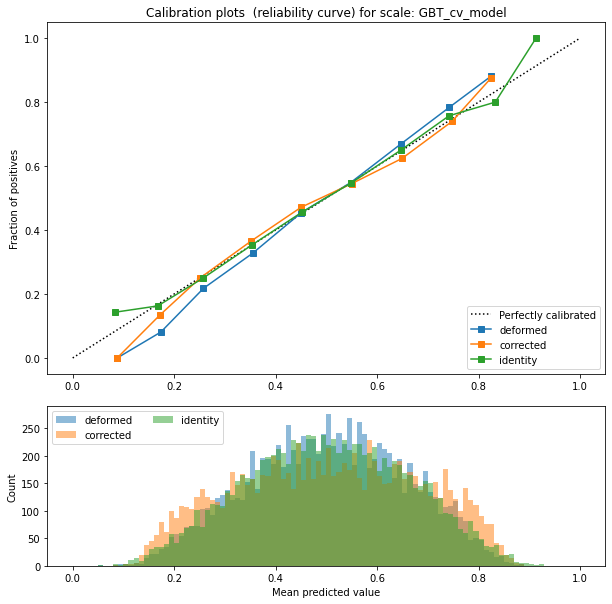

In [120]:
# fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(10,10))
# axes[0][1] = 
utils.plot_calibration_curve(res_dict, 'GBT_cv_model')

In [1017]:
exp3 = utils.xgboost_fit(variables, t)

exp3

AttributeError: module 'utils' has no attribute 'xgboost_fit'

In [1026]:
calib_df.to_csv('30_06_df.csv', index_label='simulation_run')

In [44]:
res_dict['models']['GBT_model']

{'deformed': array([0.61647413, 0.67757636, 0.34086524, ..., 0.53985917, 0.29909661,
        0.30502208]),
 'corrected': array([0.61529655, 0.67798831, 0.31639572, ..., 0.53119101, 0.27721658,
        0.28258994]),
 'identity': array([0.61647413, 0.67757636, 0.34086524, ..., 0.53985917, 0.29909661,
        0.30502208])}

In [ ]:
def get_points(df, calib_metric, y_metric='ATE_error'):
    if df.shape[0] != 2: 
        print('warning!')
        display(df)
        raise ValueError('Bad df')
    x_y_orig = df.loc[df['calibration_type'].isna(), [calib_metric, y_metric]]
    x_y_calib = df.loc[~df['calibration_type'].isna(), [calib_metric, y_metric]]
    return (x_y_orig[calib_metric].iloc[0],
            x_y_orig[y_metric].iloc[0],
            (x_y_calib[calib_metric].iloc[0] - x_y_orig[calib_metric].iloc[0]),
            (x_y_calib[y_metric].iloc[0] - x_y_orig[y_metric].iloc[0]))

def get_arrows(df, calib_metric, y_metric='ATE_error'):

    gb = df.reset_index().groupby('index')

    arrows = []
    for g in gb.groups:
        arrows.append(gb.get_group(g).groupby('scale').apply(get_points, calib_metric, y_metric))

    arrows = pd.concat(arrows)
    return arrows


def plot_arrow(values):
    plt.arrow(*values, length_includes_head=True, lw=0.1, alpha=0.4, ls='--');

In [ ]:
plt.figure(figsize=(10,10))
temp_df = calib_df[model_rows].loc[lambda df: df['type'].str.contains('cv')]
sns.scatterplot(x='mean', y='ATE_error', data=temp_df, hue='type')
# plt.ylim(-0.01, 0.6)
# plt.xlim(-.01, 0.16)

plt.xlabel('E mean', fontdict={'weight': 'bold', 'size':17})
plt.ylabel('ATE Error', fontdict={'weight': 'bold', 'size':17})

arrows = get_arrows(temp_df, calib_metric='mean')

arrows.apply(plot_arrow);

In [261]:
from causallib.datasets import load_acic16




In [291]:
x_acic = load_acic16(instance=1, raw=False)['X']

/Users/romg/opt/anaconda3/lib/python3.8/site-packages/causallib/datasets/data_loader.py:135: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  y = y.lookup(y.index, a)  # Choose the outcome based on the treatment assignment


In [286]:
res_df = pd.read_csv('var.csv', index_col=[0])


,z,y,y.0,y.1,mu.0,mu.1,e
1,0,3.157727,3.157727,7.441336,3.890563,5.716108,0.451172
2,0,4.281244,4.281244,8.937312,5.870844,8.913574,0.403919
3,0,7.621447,7.621447,8.919930,7.006040,10.022676,0.517100
4,1,4.015639,-1.828240,4.015639,-1.046089,2.952779,0.388094
5,0,-0.240268,-0.240268,5.296278,-0.478072,6.246069,0.394039
...,...,...,...,...,...,...,...
4798,1,6.861145,2.868927,6.861145,3.468946,5.867435,0.323233
4799,1,9.796457,4.512699,9.796457,4.827529,9.988942,0.398313
4800,1,10.910222,3.807379,10.910222,4.183918,9.469441,0.250085
4801,1,12.444005,5.168389,12.444005,4.684806,11.919826,0.270711


RollingGroupby [window=3,min_periods=1,center=False,axis=0]